In [2]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
import time
from math import log, e
import math

In [2]:
# Function to evaluate the entropy of a vector
# INPUTS
# - labels: vector to compute entropy
# - base: base of the log for the computation of entropy
# OUTPUT: entropy values
def entropy(labels, base=None):

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed

def entropy_analysis(file):
    num_bytes = math.ceil(len(file)/8)
    h_vector = np.zeros(num_bytes)
    for i in range(num_bytes):
        h_vector[i] = entropy(file[0:8*(i+1)], base=2)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(1,length-1):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[0]+diff_vec[-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, start, best_hl):
    vec = np.zeros(best_hl)
    for i in range(best_hl):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

def accuracies(threshold, area, y):
    accur, err = 0.0, 0.0
    if y==False and area > threshold:
        accur = 1.0
    # True positives
    if y==True and area <= threshold:
        accur = 1.0
    # False negatives
    if y==True and area > threshold:
        err = 1.0
    # False positives
    if y==False and area <= threshold:
        err = 1.0
    return accur, err

def trapezoidal_rule(ideal_file, file_vector, best_hl):
    h_ideal = entropy_analysis(ideal_file[0:best_hl])
    h = entropy_analysis(file_vector[0:best_hl])
    return diff_area(h_ideal,h)

def get_areas(file, best_hl, num_fragms):
    begin = start = 0
    i = 1
    bound = len(file) // num_fragms
    if len(file) < num_fragms * best_hl:
        bound = len(file) // (len(file) // best_hl)
    areas = []
    while i <= num_fragms and len(file) >= i*best_hl and start < len(file) - best_hl:
        file_vector = file_to_vector(file, start, best_hl)
        areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
        begin = start + best_hl
        if begin >= len(file) - best_hl:
            begin = i * bound
        if i == num_fragms and begin < len(file) - best_hl:
            if begin < len(file) - best_hl -1:
                start = randint(begin, len(file) - best_hl -1)
            elif begin == len(file) - best_hl -1:
                start = begin
        else:
            if begin < (i+1) * bound - best_hl -1:
                start = randint(begin, (i+1) * bound - best_hl -1)
            elif begin == (i+1) * bound - best_hl -1:
                start = begin
        i+=1
    return areas

def get_avg_area(distance, areas):
    best_area = 0
    i=2
    mean_random_area = areas[1]
    while i < len(areas):
        mean_random_area = mean_random_area + areas[i]
        i+=1
    mean_random_area = mean_random_area / (i-1)
    if areas[0] - distance < mean_random_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], mean_random_area)
    return best_area

def get_max_area(distance, areas):
    best_area = 0
    i=2
    rand_Fs_best_area = areas[1]
    while i < len(areas):
        rand_Fs_best_area = max(rand_Fs_best_area, areas[i])
        i+=1
    if areas[0] - distance < rand_Fs_best_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], rand_Fs_best_area)
    return best_area

def update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area):
    # Iterate over different threshold values
    if paths[j][20:25] == "EXTRA":
        results = accuracies(best_thresh, best_area, True)
        acc[j] = np.add(acc[j], results[0], dtype=float)
        true_positives[j] = np.add(true_positives[j], results[0], dtype=float)
        false_negatives[j] = np.add(false_negatives[j], results[1], dtype=float)
    else:
        results = accuracies(best_thresh, best_area, False)
        acc[j] = np.add(acc[j], results[0], dtype=float)
        true_negatives[j] = np.add(true_negatives[j], results[0], dtype=float)
        false_positives[j] = np.add(false_positives[j], results[1], dtype=float)

## BEST MODEL FOR DAA ON ORIGINAL DATASET APPLIED ON THE ORG + COMMON SEQUENCES DATASET

In [3]:
thresholds = np.arange(8,80,2)
offset = 256
acc_des=np.load('../results/acc_DAA_org.npy')
acc_des = acc_des.reshape(len(thresholds), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_hl = thresholds[ind[0]], 8*(ind[1]+1)

In [4]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset_cs.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc_DAA_cs = np.zeros([len(paths)], dtype = float)
true_positives_DAA_cs = np.zeros([len(paths)], dtype = float)
false_negatives_DAA_cs = np.zeros([len(paths)], dtype = float)
true_negatives_DAA_cs = np.zeros([len(paths)], dtype = float)
false_positives_DAA_cs = np.zeros([len(paths)], dtype = float)

In [5]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*best_hl:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            area = trapezoidal_rule(ideal_file, file_vector, best_hl)
            update_statistics(best_thresh, paths, j, acc_DAA_cs, false_positives_DAA_cs, false_negatives_DAA_cs, true_positives_DAA_cs, true_negatives_DAA_cs, area)
            files_analyzed[j] += 1
        f.close()

acc_DAA_cs = np.multiply(np.true_divide(acc_DAA_cs, files_analyzed), 100.0, dtype=float)

time_spentDAA = time.time() - start_time
files_analyzedDAA = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spentDAA//60, ((time_spentDAA)-60*((time_spentDAA)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-common-sequences
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ../NapierOneDataset/EXTRA/RANS

In [6]:
print("Best parameters: threshold %2d, header length %2d" % (best_thresh, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_DAA_cs)
print("Accuracy: %3.2f" % (accur))

acc_cs = np.mean(acc_DAA_cs[:9])
print("Accuracy on common sequences: %3.2f" % (acc_cs))
TP_mean = np.mean(true_positives_DAA_cs)
FP_mean = np.mean(false_positives_DAA_cs)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(false_negatives_DAA_cs)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_org = acc_DAA_cs[9:]
TN_org = true_negatives_DAA_cs[9:]
TP_org = true_positives_DAA_cs[9:]
FN_org = false_negatives_DAA_cs[9:]
FP_org = false_positives_DAA_cs[9:]

accur = np.mean(acc_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_org)
FP_mean = np.mean(FP_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 40, header length 152
STATISTICS ON MIXED DATASET
Accuracy: 75.00
Accuracy on common sequences: 0.00
Precision: 99.53
Recall: 47.44
F1: 64.26
STATISTICS ON ORIGINAL DATASET
Accuracy: 98.28
Precision: 99.53
Recall: 94.89
F1: 97.16


## BEST MODEL FOR DAA ON PARTIAL MIXED DATASET

In [5]:
thresholds = np.arange(8,80,2)
offset = 256
acc_des=np.load('../results/acc_DAA_part_mix.npy')
acc_des = acc_des.reshape(len(thresholds), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_hl = thresholds[ind[0]], 8*(ind[1]+1)

In [6]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc_DAA = np.zeros([len(paths)], dtype = float)
true_positives_DAA = np.zeros([len(paths)], dtype = float)
false_negatives_DAA = np.zeros([len(paths)], dtype = float)
true_negatives_DAA = np.zeros([len(paths)], dtype = float)
false_positives_DAA = np.zeros([len(paths)], dtype = float)

In [5]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*best_hl:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            area = trapezoidal_rule(ideal_file, file_vector, best_hl)
            update_statistics(best_thresh, paths, j, acc_DAA, false_positives_DAA, false_negatives_DAA, true_positives_DAA, true_negatives_DAA, area)
            files_analyzed[j] += 1
        f.close()

acc_DAA = np.multiply(np.true_divide(acc_DAA, files_analyzed), 100.0, dtype=float)

time_spentDAA = time.time() - start_time
files_analyzedDAA = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spentDAA//60, ((time_spentDAA)-60*((time_spentDAA)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [6]:
print("Best parameters: threshold %2d, header length %2d" % (best_thresh, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_DAA)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(true_positives_DAA)
FP_mean = np.mean(false_positives_DAA)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(false_negatives_DAA)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_org = acc_DAA[27:]
TN_org = true_negatives_DAA[27:]
TP_org = true_positives_DAA[27:]
FN_org = false_negatives_DAA[27:]
FP_org = false_positives_DAA[27:]

accur = np.mean(acc_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_org)
FP_mean = np.mean(FP_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 40, header length 224
STATISTICS ON MIXED DATASET
Accuracy: 50.32
Precision: 100.00
Recall: 22.72
F1: 37.03
STATISTICS ON ORIGINAL DATASET
Accuracy: 97.17
Precision: 100.00
Recall: 90.89
F1: 95.23


## BEST MODEL FOR DAA, MIXED DATASET

In [7]:
thresholds = np.arange(8,80,2)
offset = 256
acc_des=np.load('../results/acc_DAA_mix.npy')
acc_des = acc_des.reshape(len(thresholds), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_hl = thresholds[ind[0]], 8*(ind[1]+1)

In [8]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [8]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*best_hl:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            area = trapezoidal_rule(ideal_file, file_vector, best_hl)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spentDAA = time.time() - start_time
files_analyzedDAA = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spentDAA//60, ((time_spentDAA)-60*((time_spentDAA)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [19]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_DAA_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_DAA_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_DAA_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_DAA_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_DAA_mix.npy", false_positives, fix_imports=False)

In [54]:
# deserialize the tensor from the file .npy
acc_DAA_mix=np.load('../results/paths_acc_DAA_mix.npy')

TN_DAA_mix=np.load('../results/paths_TN_DAA_mix.npy')

TP_DAA_mix=np.load('../results/paths_TP_DAA_mix.npy')

FN_DAA_mix=np.load('../results/paths_FN_DAA_mix.npy')

FP_DAA_mix=np.load('../results/paths_FP_DAA_mix.npy')

In [26]:
print("Best parameters: threshold %2d, header length %2d" % (best_thresh, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_DAA_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_DAA_mix)
FP_mean = np.mean(FP_DAA_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_DAA_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_DAA_org = acc_DAA_mix[27:]
TN_DAA_org = TN_DAA_mix[27:]
TP_DAA_org = TP_DAA_mix[27:]
FN_DAA_org = FN_DAA_mix[27:]
FP_DAA_org = FP_DAA_mix[27:]

accur = np.mean(acc_DAA_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_DAA_org)
FP_mean = np.mean(FP_DAA_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_DAA_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 14, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 64.25
Precision: 91.96
Recall: 48.64
F1: 63.63
STATISTICS ON ORIGINAL DATASET
Accuracy: 93.03
Precision: 84.76
Recall: 94.56
F1: 89.39


## BEST MODEL FOR 2F, MIXED DATASET

In [10]:
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
offset = 256
acc_des=np.load('../results/acc_2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [11]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [5]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*best_hl:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            # Second fragment
            start = randint(best_hl, len(file) - best_hl)                
            file_vector = file_to_vector(file, start, best_hl)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            
            if areas[0] > areas[1] and areas[0] - best_dist < areas[1]:
                best_area = areas[0]
            else:
                best_area = min(areas[0], areas[1])

            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent2F = time.time() - start_time
files_analyzed2F = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent2F//60, ((time_spent2F)-60*((time_spent2F)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [6]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_2F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_2F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_2F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_2F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_2F_mix.npy", false_positives, fix_imports=False)

In [2]:
# deserialize the tensor from the file .npy
acc_2F_mix=np.load('../results/paths_acc_2F_mix.npy')

TN_2F_mix=np.load('../results/paths_TN_2F_mix.npy')

TP_2F_mix=np.load('../results/paths_TP_2F_mix.npy')

FN_2F_mix=np.load('../results/paths_FN_2F_mix.npy')

FP_2F_mix=np.load('../results/paths_FP_2F_mix.npy')

#### STATISTICS

In [8]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_2F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_2F_mix)
FP_mean = np.mean(FP_2F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_2F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_2F_org = acc_2F_mix[27:]
TN_2F_org = TN_2F_mix[27:]
TP_2F_org = TP_2F_mix[27:]
FN_2F_org = FN_2F_mix[27:]
FP_2F_org = FP_2F_mix[27:]

accur = np.mean(acc_2F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_2F_org)
FP_mean = np.mean(FP_2F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_2F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 12, distance 54, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 92.78
Precision: 94.51
Recall: 94.25
F1: 94.38
STATISTICS ON ORIGINAL DATASET
Accuracy: 90.72
Precision: 80.78
Recall: 92.00
F1: 86.03


## BEST MODEL FOR SW-2F, MIXED DATASET

In [13]:
thresholds = np.arange(2,35,1)
distances = np.arange(48,80,2)
offset = 256
acc_des=np.load('../results/acc_SW2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [14]:
offset = 256
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [17]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 3*offset:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            # Second fragment
            start = randint(best_hl, len(file) - (offset+64*3))
            vector = file_to_vector(file, start, offset+64*3)
            for sw in range(0,4):
                file_vector = vector[0+64*sw:256+64*sw]
                areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            
            best_area = get_avg_area(best_dist, areas)

            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spentSW2F = time.time() - start_time
files_analyzedSW2F = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spentSW2F//60, ((time_spentSW2F)-60*((time_spentSW2F)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [18]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_SW2F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_SW2F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_SW2F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_SW2F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_SW2F_mix.npy", false_positives, fix_imports=False)

In [3]:
# deserialize the tensor from the file .npy
acc_SW2F_mix=np.load('../results/paths_acc_SW2F_mix.npy')

TN_SW2F_mix=np.load('../results/paths_TN_SW2F_mix.npy')

TP_SW2F_mix=np.load('../results/paths_TP_SW2F_mix.npy')

FN_SW2F_mix=np.load('../results/paths_FN_SW2F_mix.npy')

FP_SW2F_mix=np.load('../results/paths_FP_SW2F_mix.npy')

#### STATISTICS

In [20]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_SW2F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_SW2F_mix)
FP_mean = np.mean(FP_SW2F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_SW2F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_SW2F_org = acc_SW2F_mix[27:]
TN_SW2F_org = TN_SW2F_mix[27:]
TP_SW2F_org = TP_SW2F_mix[27:]
FN_SW2F_org = FN_SW2F_mix[27:]
FP_SW2F_org = FP_SW2F_mix[27:]

accur = np.mean(acc_SW2F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_SW2F_org)
FP_mean = np.mean(FP_SW2F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_SW2F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 11, distance 52, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 77.32
Precision: 92.81
Recall: 70.20
F1: 79.94
STATISTICS ON ORIGINAL DATASET
Accuracy: 91.30
Precision: 81.23
Recall: 93.81
F1: 87.06


## BEST MODEL FOR 3F, MIXED DATASET (MAX)

In [16]:
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_3F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [17]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 3

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [94]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*best_hl:
            areas = get_areas(file, best_hl, num_fragms)
            best_area = get_max_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent3Fmax = time.time() - start_time
files_analyzed3Fmax = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent3Fmax//60, ((time_spent3Fmax)-60*((time_spent3Fmax)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [95]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_3F_mix_max.npy", acc, fix_imports=False)

np.save("../results/paths_TN_3F_mix_max.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_3F_mix_max.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_3F_mix_max.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_3F_mix_max.npy", false_positives, fix_imports=False)

In [4]:
# deserialize the tensor from the file .npy
acc_3F_mix_max=np.load('../results/paths_acc_3F_mix_max.npy')

TN_3F_mix_max=np.load('../results/paths_TN_3F_mix_max.npy')

TP_3F_mix_max=np.load('../results/paths_TP_3F_mix_max.npy')

FN_3F_mix_max=np.load('../results/paths_FN_3F_mix_max.npy')

FP_3F_mix_max=np.load('../results/paths_FP_3F_mix_max.npy')

In [97]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_3F_mix_max)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_mix_max)
FP_mean = np.mean(FP_3F_mix_max)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_mix_max)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_3F_org_max = acc_3F_mix_max[27:]
TN_3F_org_max = TP_3F_mix_max[27:]
TP_3F_org_max = TN_3F_mix_max[27:]
FN_3F_org_max = FN_3F_mix_max[27:]
FP_3F_org_max = FP_3F_mix_max[27:]

accur = np.mean(acc_3F_org_max)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_org_max)
FP_mean = np.mean(FP_3F_org_max)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_org_max)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 12, distance 46, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 91.34
Precision: 93.08
Recall: 93.47
F1: 93.28
STATISTICS ON ORIGINAL DATASET
Accuracy: 89.10
Precision: 87.47
Recall: 96.36
F1: 91.70


## BEST MODEL FOR 3F, MIXED DATASET (AVG)

In [19]:
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_3F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [20]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 3

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [18]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*best_hl:
            areas = get_areas(file, best_hl, num_fragms)
            best_area = get_avg_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent3Favg = time.time() - start_time
files_analyzed3Favg = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent3Favg//60, ((time_spent3Favg)-60*((time_spent3Favg)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [56]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_3F_mix_avg.npy", acc, fix_imports=False)

np.save("../results/paths_TN_3F_mix_avg.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_3F_mix_avg.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_3F_mix_avg.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_3F_mix_avg.npy", false_positives, fix_imports=False)

In [5]:
# deserialize the tensor from the file .npy
acc_3F_mix=np.load('../results/paths_acc_3F_mix_avg.npy')

TN_3F_mix=np.load('../results/paths_TN_3F_mix_avg.npy')

TP_3F_mix=np.load('../results/paths_TP_3F_mix_avg.npy')

FN_3F_mix=np.load('../results/paths_FN_3F_mix_avg.npy')

FP_3F_mix=np.load('../results/paths_FP_3F_mix_avg.npy')

#### STATISTICS

In [12]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_3F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_mix)
FP_mean = np.mean(FP_3F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_3F_org = acc_3F_mix[27:]
TN_3F_org = TN_3F_mix[27:]
TP_3F_org = TP_3F_mix[27:]
FN_3F_org = FN_3F_mix[27:]
FP_3F_org = FP_3F_mix[27:]

accur = np.mean(acc_3F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_org)
FP_mean = np.mean(FP_3F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 10, distance 48, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 91.75
Precision: 93.53
Recall: 93.64
F1: 93.59
STATISTICS ON ORIGINAL DATASET
Accuracy: 89.86
Precision: 78.26
Recall: 93.22
F1: 85.09


## BEST MODEL FOR 4F, MIXED DATASET (MAX)

In [22]:
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_4F_mix.npy')
offset = 256
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [23]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 4

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [63]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*best_hl:
            areas = get_areas(file, best_hl, num_fragms)
            best_area = get_max_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent4Fmax = time.time() - start_time
files_analyzed4Fmax = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent4Fmax//60, ((time_spent4Fmax)-60*((time_spent4Fmax)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [64]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_4F_mix_max.npy", acc, fix_imports=False)

np.save("../results/paths_TN_4F_mix_max.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_4F_mix_max.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_4F_mix_max.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_4F_mix_max.npy", false_positives, fix_imports=False)

In [6]:
# deserialize the tensor from the file .npy
acc_4F_mix_max=np.load('../results/paths_acc_4F_mix_max.npy')

TN_4F_mix_max=np.load('../results/paths_TN_4F_mix_max.npy')

TP_4F_mix_max=np.load('../results/paths_TP_4F_mix_max.npy')

FN_4F_mix_max=np.load('../results/paths_FN_4F_mix_max.npy')

FP_4F_mix_max=np.load('../results/paths_FP_4F_mix_max.npy')

In [16]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_4F_mix_max)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_mix_max)
FP_mean = np.mean(FP_4F_mix_max)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_mix_max)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_4F_org_max = acc_4F_mix_max[27:]
TN_4F_org_max = TP_4F_mix_max[27:]
TP_4F_org_max = TN_4F_mix_max[27:]
FN_4F_org_max = FN_4F_mix_max[27:]
FP_4F_org_max = FP_4F_mix_max[27:]

accur = np.mean(acc_4F_org_max)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_org_max)
FP_mean = np.mean(FP_4F_org_max)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_org_max)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 14, distance 42, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 88.83
Precision: 89.22
Recall: 94.00
F1: 91.55
STATISTICS ON ORIGINAL DATASET
Accuracy: 84.84
Precision: 79.50
Recall: 98.14
F1: 87.84


## BEST MODEL FOR 4F, MIXED DATASET (AVG)

In [25]:
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_4F_mix_avg.npy')
offset = 256
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [26]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 4

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [23]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*best_hl:
            areas = get_areas(file, best_hl, num_fragms)
            best_area = get_avg_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent4Favg = time.time() - start_time
files_analyzed4Favg = np.sum(files_analyzed)
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent4Favg//60, ((time_spent4Favg)-60*((time_spent4Favg)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [71]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_4F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_4F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_4F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_4F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_4F_mix.npy", false_positives, fix_imports=False)

In [7]:
# deserialize the tensor from the file .npy
acc_4F_mix=np.load('../results/paths_acc_4F_mix.npy')

TN_4F_mix=np.load('../results/paths_TN_4F_mix.npy')

TP_4F_mix=np.load('../results/paths_TP_4F_mix.npy')

FN_4F_mix=np.load('../results/paths_FN_4F_mix.npy')

FP_4F_mix=np.load('../results/paths_FP_4F_mix.npy')

 #### STATISTICS

In [20]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_4F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_mix)
FP_mean = np.mean(FP_4F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_4F_org = acc_4F_mix[27:]
TN_4F_org = TP_4F_mix[27:]
TP_4F_org = TN_4F_mix[27:]
FN_4F_org = FN_4F_mix[27:]
FP_4F_org = FP_4F_mix[27:]

accur = np.mean(acc_4F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_org)
FP_mean = np.mean(FP_4F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 14, distance 56, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 92.53
Precision: 94.22
Recall: 94.17
F1: 94.19
STATISTICS ON ORIGINAL DATASET
Accuracy: 91.51
Precision: 89.57
Recall: 97.92
F1: 93.56


## PLOTS OF THE ACCURACIES FOR EACH FILE TYPE

### PREPARE ENVIROMENT VARIABLES

In [3]:
#Retrieve all data for plots
acc_DAA_mix=np.load('../results/paths_acc_DAA_mix.npy')
acc_2F_mix=np.load('../results/paths_acc_2F_mix.npy')
acc_3F_mix=np.load('../results/paths_acc_3F_mix_avg.npy')
acc_4F_mix=np.load('../results/paths_acc_4F_mix.npy')

#retrieve paths
f = open('../paths/mixed_dataset.txt', 'r')
# asse x i modelli, asse y le accuracy, colorati i vari tipi di files
paths = f.readlines()
f.close()
short_paths = paths
for i in range(len(paths)):
    p = paths[i].split("/")
    short_paths[i] = p[-1][:-1]
    short_paths[i] = short_paths[i].replace('-tiny','')
    short_paths[i] = short_paths[i].replace('RANSOMWARE-','')
    s=short_paths[i].split("-")
    if len(s) > 1:
        short_paths[i] = short_paths[i].replace(s[1],s[1][0])
    if len(s) > 2:
        short_paths[i] = short_paths[i].replace(s[2],s[2][0])
    if len(s) > 3:
        short_paths[i] = short_paths[i].replace(s[3],s[3][0])
    s=short_paths[i].split("-")
    if len(s[0]) > 4:
        short_paths[i] = short_paths[i].replace(s[0], s[0][0]+ s[0][int(len(s[0])/2)] +s[0][-1])
print("The following will be the abbreviate names for the paths:")
print(short_paths)

The following will be the abbreviate names for the paths:
['MAZE-r-c', 'DRA-r-c', 'NAR-r-c', 'NEA-r-c', 'PBS-r-c', 'RYUK-r-c', 'SOI-r-c', 'Way-r-c', 'Bat-r-c', 'MAZE-l-e-h', 'DRA-l-e-h', 'NAR-l-e-h', 'NEA-l-e-h', 'PBS-l-e-h', 'RYUK-l-e-h', 'SOI-l-e-h', 'Way-l-e-h', 'Bat-l-e-h', 'MAZE-c-s', 'DRA-c-s', 'NAR-c-s', 'NEA-c-s', 'PBS-c-s', 'RYUK-c-s', 'SOI-c-s', 'Way-c-s', 'Bat-c-s', 'MAZE', 'DRA', 'NAR', 'NEA', 'PBS', 'RYUK', 'SOI', 'Bat', 'Way', 'JPG-f-w', 'PDF', 'PPTX', 'XLS', 'XLSX', '7ZIP-B', '7ZIP-E', '7ZIP-H-C', 'CSS', 'DLL', 'GIF', 'MKV', 'MP3', 'MP4', 'PNG-c', 'RAR', 'TAR', 'XML', 'DOCX', 'DOC']


In [4]:
#make notation coherent
acc_DAA_mix[34], acc_DAA_mix[35] = acc_DAA_mix[35], acc_DAA_mix[34]
acc_2F_mix[34], acc_2F_mix[35] = acc_2F_mix[35], acc_2F_mix[34]
acc_3F_mix[34], acc_3F_mix[35] = acc_3F_mix[35], acc_3F_mix[34]
acc_4F_mix[34], acc_4F_mix[35] = acc_4F_mix[35], acc_4F_mix[34]
short_paths[34], short_paths[35] = short_paths[35], short_paths[34]

### PLOTS

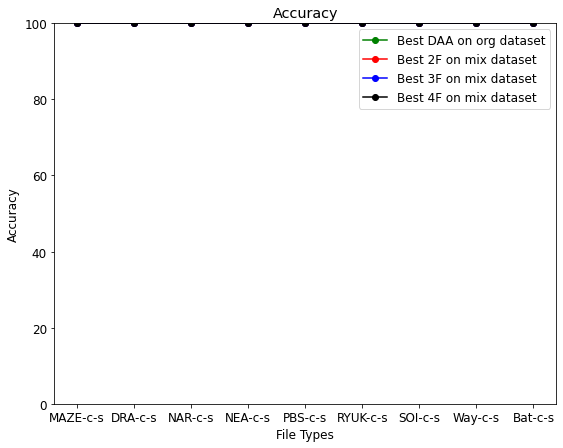

In [30]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,7))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")
plt.plot(short_paths[18:27], acc_DAA_mix[18:27], marker='o', color="green", label="Best DAA on org dataset")
plt.plot(short_paths[18:27], acc_2F_mix[18:27], marker='o', color="red", label="Best 2F on mix dataset")
plt.plot(short_paths[18:27], acc_3F_mix[18:27], marker='o', color="blue", label="Best 3F on mix dataset")
plt.plot(short_paths[18:27], acc_4F_mix[18:27], marker='o', color="black", label="Best 4F on mix dataset")
plt.ylim([0, 100])
plt.legend()
plt.show()

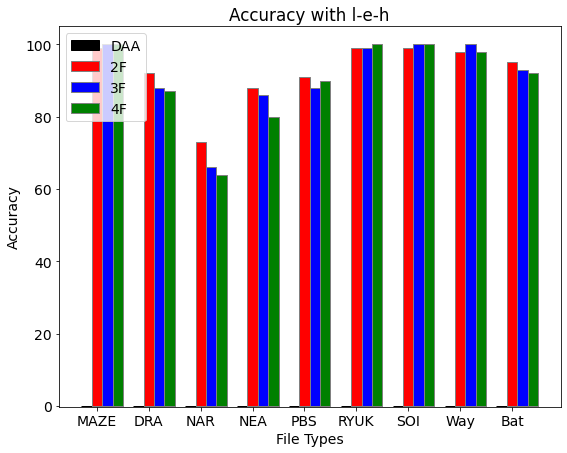

In [23]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9,7))
plt.title("Accuracy with l-e-h")
plt.xlabel("File Types")
plt.ylabel("Accuracy")
barWidth = 0.20
br1 = np.arange(len(short_paths[27:36]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
plt.bar(br1, acc_DAA_mix[9:18], tick_label = short_paths[27:36], width=barWidth, color='black', edgecolor ='black', label ='DAA')
plt.bar(br2, acc_2F_mix[9:18], tick_label = short_paths[27:36], width=barWidth, color='red', edgecolor ='grey', label ='2F')
plt.bar(br3, acc_3F_mix[9:18], tick_label = short_paths[27:36], width=barWidth, color='blue', edgecolor ='grey', label ='3F')
plt.bar(br4, acc_4F_mix[9:18], tick_label = short_paths[27:36], width=barWidth, color='green', edgecolor ='grey', label ='4F')
plt.xticks([r + barWidth for r in range(len(short_paths[27:36]))],short_paths[27:36])
plt.ylim([-0.2, 105])
plt.legend()
plt.savefig('../Img/acc_l-e-h_bars.pdf')
plt.show()


### OLD VERSION ###
# plt.plot(short_paths[9:18], acc_DAA_mix[9:18], marker='o', color="red", label="Best DAA on org dataset")
# plt.plot(short_paths[9:18], acc_2F_mix[9:18], marker='o', color="green", label="Best 2F on mix dataset")
# plt.plot(short_paths[9:18], acc_3F_mix[9:18], marker='o', color="blue", label="Best 3F on mix dataset")
# plt.plot(short_paths[9:18], acc_4F_mix[9:18], marker='o', color="black", label="Best 4F on mix dataset")
# plt.ylim([0, 100])
# plt.legend()
# plt.savefig('../Img/acc_l-e-h.pdf')
# plt.show()

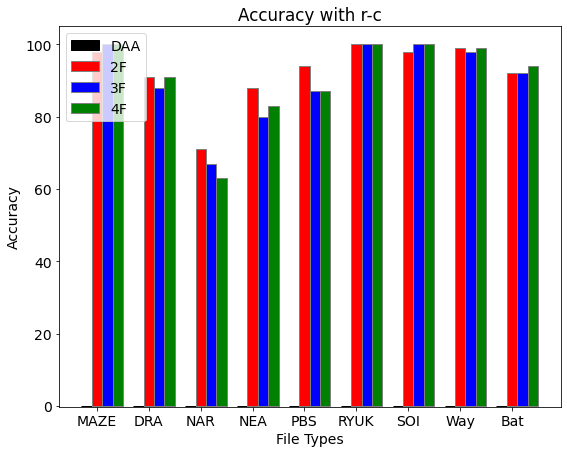

In [22]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9,7))
plt.title("Accuracy with r-c")
plt.xlabel("File Types")
plt.ylabel("Accuracy")
barWidth = 0.20
br1 = np.arange(len(short_paths[27:36]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
plt.bar(br1, acc_DAA_mix[0:9], tick_label = short_paths[27:36], width=barWidth, color='black', edgecolor ='black', label ='DAA')
plt.bar(br2, acc_2F_mix[0:9], tick_label = short_paths[27:36], width=barWidth, color='red', edgecolor ='grey', label ='2F')
plt.bar(br3, acc_3F_mix[0:9], tick_label = short_paths[27:36], width=barWidth, color='blue', edgecolor ='grey', label ='3F')
plt.bar(br4, acc_4F_mix[0:9], tick_label = short_paths[27:36], width=barWidth, color='green', edgecolor ='grey', label ='4F')
plt.xticks([r + barWidth for r in range(len(short_paths[27:36]))],short_paths[27:36])
plt.ylim([-0.2, 105])
plt.legend()
plt.savefig('../Img/acc_r-c_bars.pdf')
plt.show()

### OLD VERSION ###
# plt.plot(short_paths[0:9], acc_DAA_mix[0:9], marker='o', color="red", label="Best DAA on org dataset")
# plt.plot(short_paths[0:9], acc_2F_mix[0:9], marker='o', color="green", label="Best 2F on mix dataset")
# plt.plot(short_paths[0:9], acc_3F_mix[0:9], marker='o', color="blue", label="Best 3F on mix dataset")
# plt.plot(short_paths[0:9], acc_4F_mix[0:9], marker='o', color="black", label="Best 4F on mix dataset")
# plt.ylim([0, 100])
# plt.legend()
# plt.savefig('../Img/acc_r-c.pdf')
# plt.show()

#### RANDOMLY PLOT THE ACCURACIES FOR 23 DIFFERENT FILE TYPES

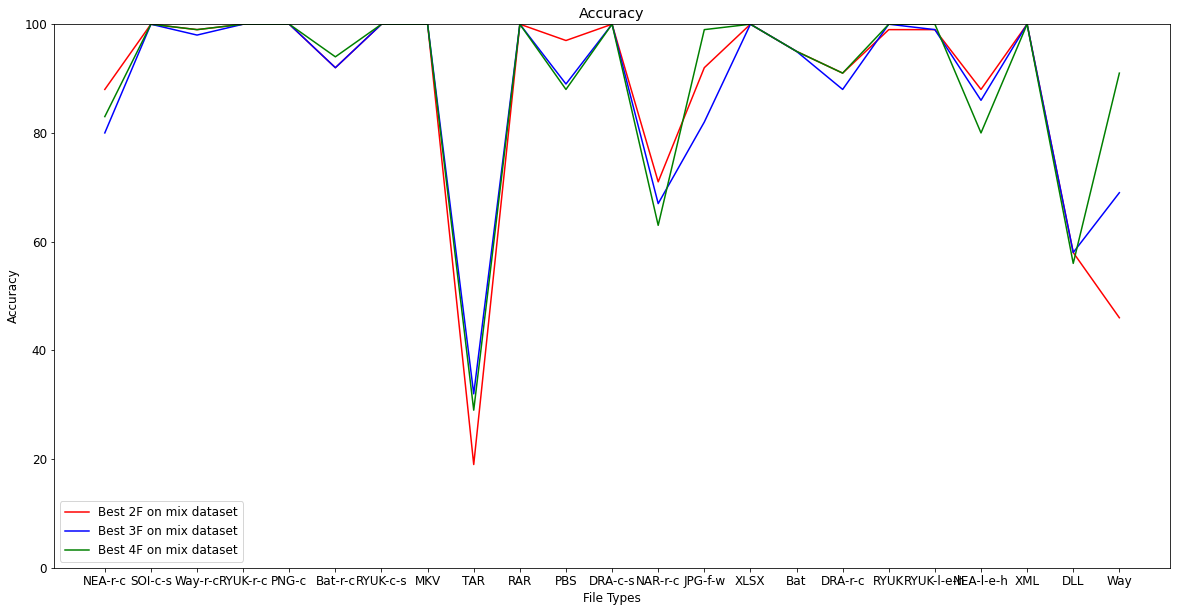

In [33]:
plt.figure(figsize=(20,10))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")

num_paths = 23
new_acc_2F_mix=np.zeros(num_paths, dtype=float)
new_acc_3F_mix=np.zeros(num_paths, dtype=float)
new_acc_4F_mix=np.zeros(num_paths, dtype=float)
new_paths=[]
indexes=np.full(num_paths, 56, dtype = int)

for i in range(0,num_paths):
    r = randint(0, len(short_paths)-1)
    while r in indexes:
        r = randint(0, len(short_paths)-1)
    indexes[i] = r
    new_acc_2F_mix[i] = acc_2F_mix[r]
    new_acc_3F_mix[i] = acc_3F_mix[r]
    new_acc_4F_mix[i] = acc_4F_mix[r]
    new_paths.append(short_paths[r])


plt.plot(new_paths, new_acc_2F_mix, color="red", label="Best 2F on mix dataset")
plt.plot(new_paths, new_acc_3F_mix, color="blue", label="Best 3F on mix dataset")
plt.plot(new_paths, new_acc_4F_mix, color="green", label="Best 4F on mix dataset")
plt.ylim([0, 100])
plt.legend()
plt.show()

#### PLOT THE ACCURACIES FOR THE ORIGINAL DATASET

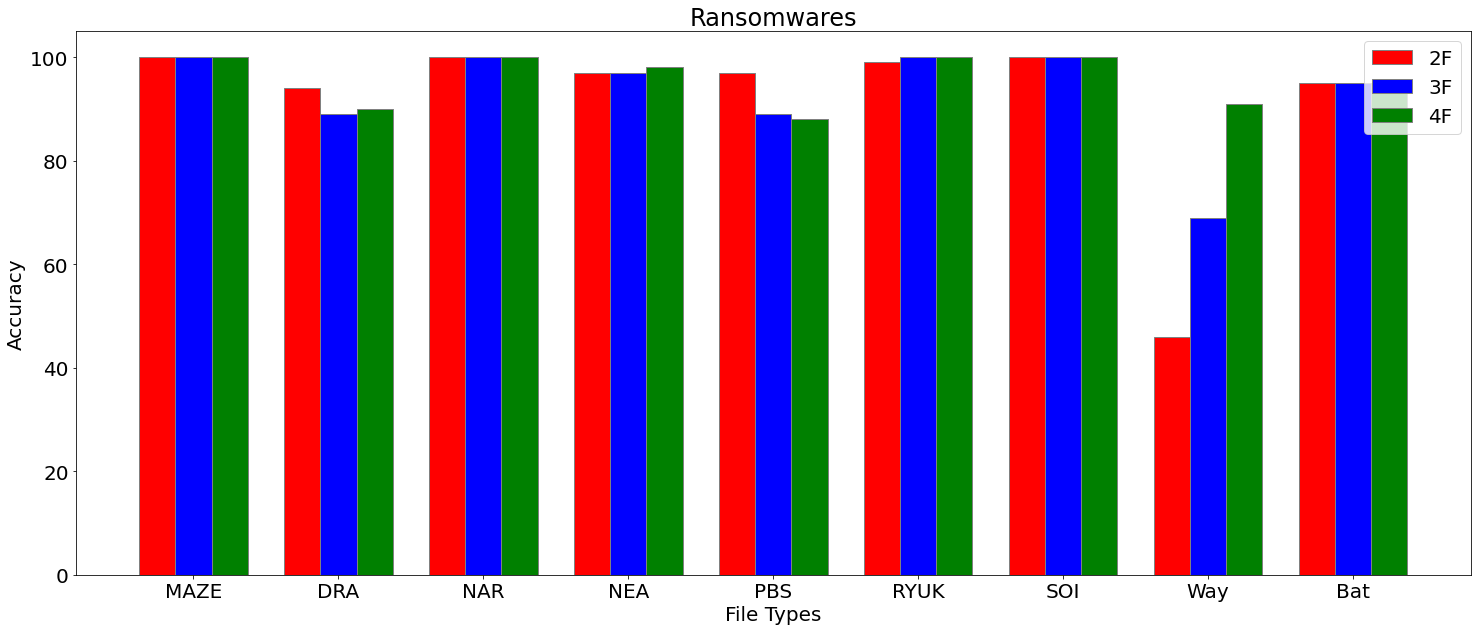

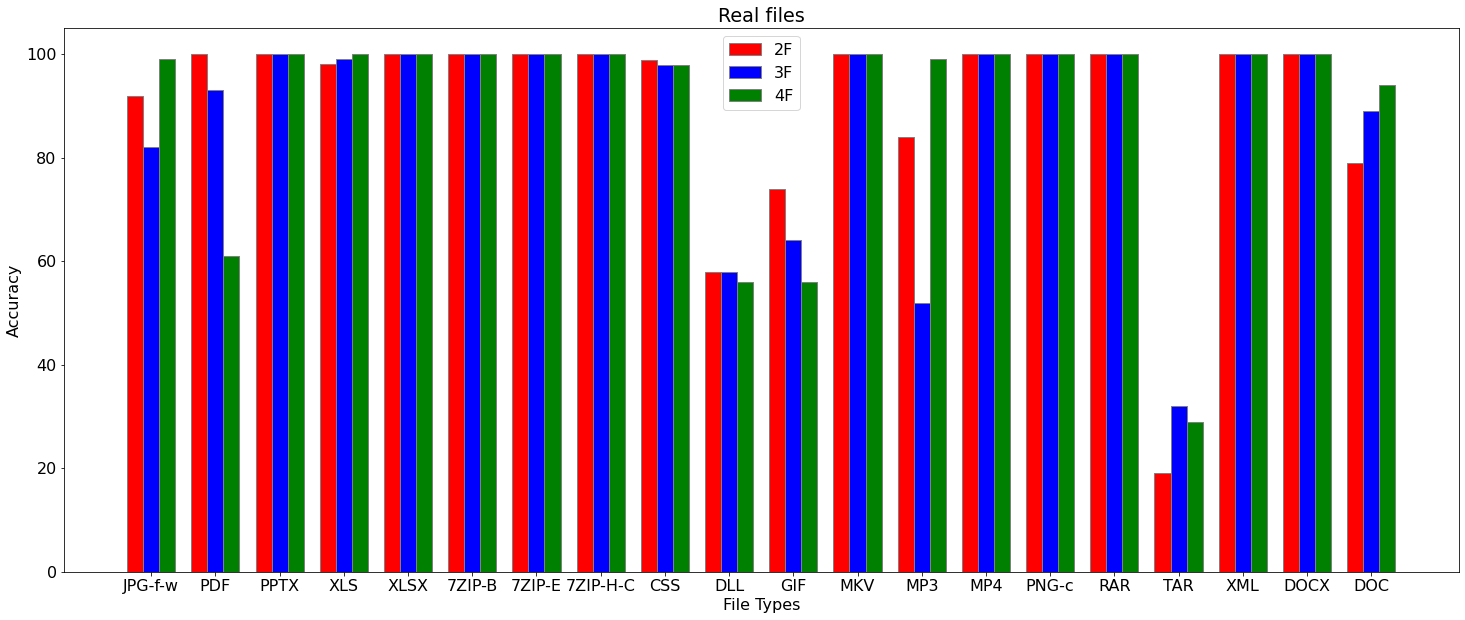

In [26]:
#plot ransomwares
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(25,10))
plt.title("Ransomwares")
plt.xlabel("File Types")
plt.ylabel("Accuracy")
barWidth = 0.25
br1 = np.arange(len(short_paths[27:36]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, acc_2F_mix[27:36], tick_label = short_paths[27:36], width=barWidth, color='red', edgecolor ='grey', label ='2F')
plt.bar(br2, acc_3F_mix[27:36], tick_label = short_paths[27:36], width=barWidth, color='blue', edgecolor ='grey', label ='3F')
plt.bar(br3, acc_4F_mix[27:36], tick_label = short_paths[27:36], width=barWidth, color='green', edgecolor ='grey', label ='4F')
plt.xticks([r + barWidth for r in range(len(short_paths[27:36]))],short_paths[27:36])
plt.legend()
plt.savefig('../Img/plot_acc_org_ransom_bars.pdf')
plt.show()

#plot normal files
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(25,10))
plt.title("Real files")
plt.xlabel("File Types")
plt.ylabel("Accuracy")
barWidth = 0.25
br1 = np.arange(len(short_paths[36:]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, acc_2F_mix[36:], tick_label = short_paths[36:], width=barWidth, color='red', edgecolor ='grey', label ='2F')
plt.bar(br2, acc_3F_mix[36:], tick_label = short_paths[36:], width=barWidth, color='blue', edgecolor ='grey', label ='3F')
plt.bar(br3, acc_4F_mix[36:], tick_label = short_paths[36:], width=barWidth, color='green', edgecolor ='grey', label ='4F')
plt.xticks([r + barWidth for r in range(len(short_paths[36:]))],short_paths[36:])
plt.legend()
plt.savefig('../Img/plot_acc_org_common_bars.pdf')
plt.show()


### OLD VERSION ###
#plt.plot(short_paths[27:], acc_DAA_mix[27:], marker='o', color="orange", label="Best DAA on mix dataset")
# plt.plot(short_paths[27:], acc_2F_mix[27:], marker='o', color="red", label="Best 2F on mix dataset")
# plt.plot(short_paths[27:], acc_3F_mix[27:], marker='o', color="blue", label="Best 3F on mix dataset")
# plt.plot(short_paths[27:], acc_4F_mix[27:], marker='o', color="green", label="Best 4F on mix dataset")
# plt.ylim([0, 100])
# plt.legend()

#plt.savefig('../Img/plot_acc_org.pdf')


#### PLOT THE ACCURACIES FOR THE FORGED FILES IN THE DATASET

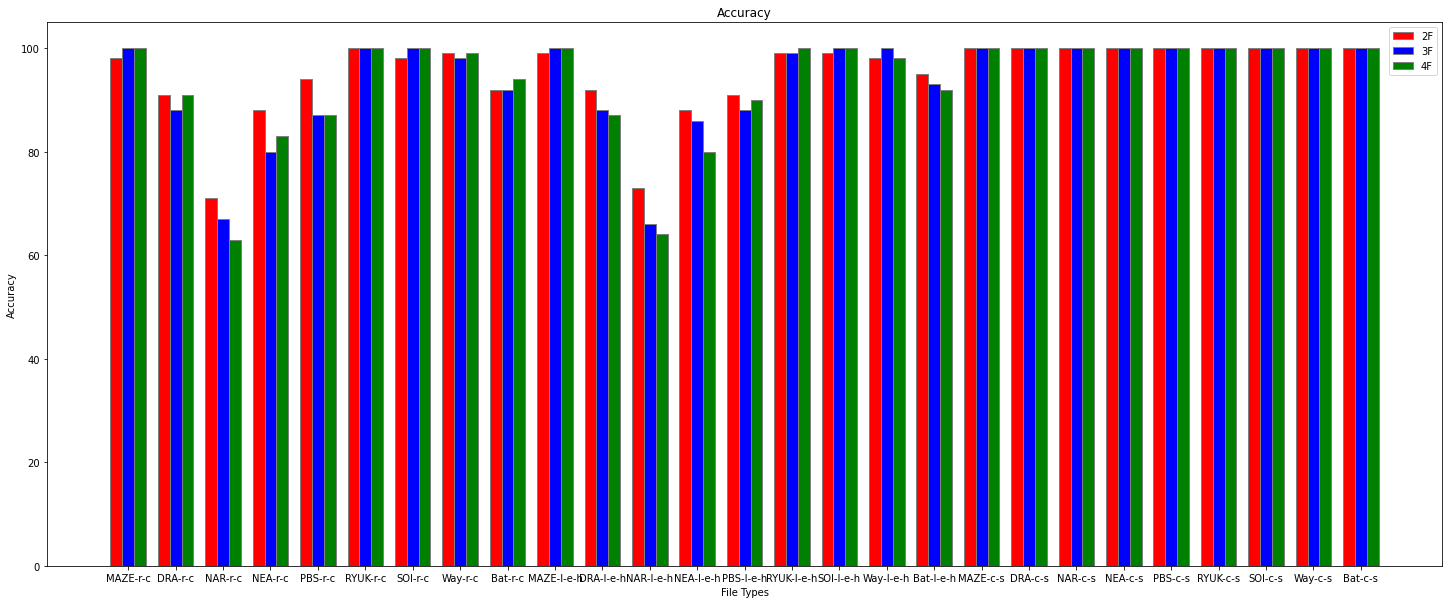

In [40]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(25,10))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")

# plt.plot(short_paths[:27], acc_2F_mix[:27], marker='o', color="red", label="Best 2F on mix dataset")
# plt.plot(short_paths[:27], acc_3F_mix[:27], marker='o', color="blue", label="Best 3F on mix dataset")
# plt.plot(short_paths[:27], acc_4F_mix[:27], marker='o', color="green", label="Best 4F on mix dataset")
# plt.ylim([0, 100])
barWidth = 0.25
br1 = np.arange(len(short_paths[:27]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, acc_2F_mix[:27], tick_label = short_paths[:27], width=barWidth, color='red', edgecolor ='grey', label ='2F')
plt.bar(br2, acc_3F_mix[:27], tick_label = short_paths[:27], width=barWidth, color='blue', edgecolor ='grey', label ='3F')
plt.bar(br3, acc_4F_mix[:27], tick_label = short_paths[:27], width=barWidth, color='green', edgecolor ='grey', label ='4F')
plt.xticks([r + barWidth for r in range(len(short_paths[:27],))],short_paths[:27])
plt.legend()
plt.show()

In [33]:
#../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-low-entropy-header
print("Accuracy of 2F on PHOBOS-tiny-low-entropy-header:", acc_2F_mix[13])
print("Accuracy of DAA on PHOBOS-tiny-low-entropy-header:", acc_DAA_mix[13])
print("Accuracy of 3F on PHOBOS-tiny-low-entropy-header:", acc_3F_mix[13])
print("Accuracy of 4F on PHOBOS-tiny-low-entropy-header:", acc_4F_mix[13])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-low-entropy-header
print("Accuracy of 2F on NETWALKER-tiny-low-entropy-header:", acc_2F_mix[11])
print("Accuracy of DAA on NETWALKER-tiny-low-entropy-header:", acc_DAA_mix[11])
print("Accuracy of 3F on NETWALKER-tiny-low-entropy-header:", acc_3F_mix[11])
print("Accuracy of 4F on NETWALKER-tiny-low-entropy-header:", acc_4F_mix[11])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/Wannacry-tiny-common-sequences
print("Accuracy of 2F on Wannacry-tiny-common-sequences:", acc_2F_mix[25])
print("Accuracy of DAA on Wannacry-tiny-common-sequences:", acc_DAA_mix[25])
print("Accuracy of 3F on Wannacry-tiny-common-sequences:", acc_3F_mix[25])
print("Accuracy of 4F on Wannacry-tiny-common-sequences:", acc_4F_mix[25])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
print("Accuracy of 2F on NETWALKER-tiny-repeat-ciphertext:", acc_2F_mix[2])
print("Accuracy of DAA on NETWALKER-tiny-repeat-ciphertext:", acc_DAA_mix[2])
print("Accuracy of 3F on NETWALKER-tiny-repeat-ciphertext:", acc_3F_mix[2])
print("Accuracy of 4F on NETWALKER-tiny-repeat-ciphertext:", acc_4F_mix[2])
print("--------------------------------------------------------------------------")

Accuracy of 2F on PHOBOS-tiny-low-entropy-header: 91.0
Accuracy of DAA on PHOBOS-tiny-low-entropy-header: 0.0
Accuracy of 3F on PHOBOS-tiny-low-entropy-header: 88.0
Accuracy of 4F on PHOBOS-tiny-low-entropy-header: 90.0
--------------------------------------------------------------------------
Accuracy of 2F on NETWALKER-tiny-low-entropy-header: 73.0
Accuracy of DAA on NETWALKER-tiny-low-entropy-header: 0.0
Accuracy of 3F on NETWALKER-tiny-low-entropy-header: 66.0
Accuracy of 4F on NETWALKER-tiny-low-entropy-header: 64.0
--------------------------------------------------------------------------
Accuracy of 2F on Wannacry-tiny-common-sequences: 100.0
Accuracy of DAA on Wannacry-tiny-common-sequences: 100.0
Accuracy of 3F on Wannacry-tiny-common-sequences: 100.0
Accuracy of 4F on Wannacry-tiny-common-sequences: 100.0
--------------------------------------------------------------------------
Accuracy of 2F on NETWALKER-tiny-repeat-ciphertext: 71.0
Accuracy of DAA on NETWALKER-tiny-repeat-

In [34]:
#../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
print("Accuracy of 2F on NOTPETYA-tiny-repeat-ciphertext:", acc_2F_mix[3])
print("Accuracy of DAA on NOTPETYA-tiny-repeat-ciphertext:", acc_DAA_mix[3])
print("Accuracy of 3F on NOTPETYA-tiny-repeat-ciphertext:", acc_3F_mix[3])
print("Accuracy of 4F on NOTPETYA-tiny-repeat-ciphertext:", acc_4F_mix[3])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
print("Accuracy of 2F on SODINOKIBI-tiny-repeat-ciphertext:", acc_2F_mix[6])
print("Accuracy of DAA on SODINOKIBI-tiny-repeat-ciphertext:", acc_DAA_mix[6])
print("Accuracy of 3F on SODINOKIBI-tiny-repeat-ciphertext:", acc_3F_mix[6])
print("Accuracy of 4F on SODINOKIBI-tiny-repeat-ciphertext:", acc_4F_mix[6])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-low-entropy-header
print("Accuracy of 2F on NOTPETYA-tiny-low-entropy-header:", acc_2F_mix[12])
print("Accuracy of DAA on NOTPETYA-tiny-low-entropy-header:", acc_DAA_mix[12])
print("Accuracy of 3F on NOTPETYA-tiny-low-entropy-header:", acc_3F_mix[12])
print("Accuracy of 4F on NOTPETYA-tiny-low-entropy-header:", acc_4F_mix[12])
print("--------------------------------------------------------------------------")
#../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-low-entropy-header
print("Accuracy of 2F on DHARMA-tiny-low-entropy-header:", acc_2F_mix[10])
print("Accuracy of DAA on DHARMA-tiny-low-entropy-header:", acc_DAA_mix[10])
print("Accuracy of 3F on DHARMA-tiny-low-entropy-header:", acc_3F_mix[10])
print("Accuracy of 4F on DHARMA-tiny-low-entropy-header:", acc_4F_mix[10])

Accuracy of 2F on NOTPETYA-tiny-repeat-ciphertext: 88.0
Accuracy of DAA on NOTPETYA-tiny-repeat-ciphertext: 0.0
Accuracy of 3F on NOTPETYA-tiny-repeat-ciphertext: 80.0
Accuracy of 4F on NOTPETYA-tiny-repeat-ciphertext: 83.0
--------------------------------------------------------------------------
Accuracy of 2F on SODINOKIBI-tiny-repeat-ciphertext: 98.0
Accuracy of DAA on SODINOKIBI-tiny-repeat-ciphertext: 0.0
Accuracy of 3F on SODINOKIBI-tiny-repeat-ciphertext: 100.0
Accuracy of 4F on SODINOKIBI-tiny-repeat-ciphertext: 100.0
--------------------------------------------------------------------------
Accuracy of 2F on NOTPETYA-tiny-low-entropy-header: 88.0
Accuracy of DAA on NOTPETYA-tiny-low-entropy-header: 0.0
Accuracy of 3F on NOTPETYA-tiny-low-entropy-header: 86.0
Accuracy of 4F on NOTPETYA-tiny-low-entropy-header: 80.0
--------------------------------------------------------------------------
Accuracy of 2F on DHARMA-tiny-low-entropy-header: 92.0
Accuracy of DAA on DHARMA-tiny-low

In [35]:
model = ["DAA", "2F", "3F", "4F"]
time = [time_spentDAA/files_analyzedDAA,time_spent2F/files_analyzed2F,time_spent3Favg/files_analyzed3Favg,time_spent4Favg/files_analyzed4Favg]
time1= [1/time[0],1/time[1],1/time[2],1/time[3]]
x_pos = np.arange(len(model))

plt.bar(x_pos, time1, align='center')
plt.xticks(x_pos, model)
plt.ylabel('Time (file per seconds)')
plt.xlabel('Model')
plt.title('Time comparison')
plt.show()
print(time1)

NameError: name 'time_spentDAA' is not defined

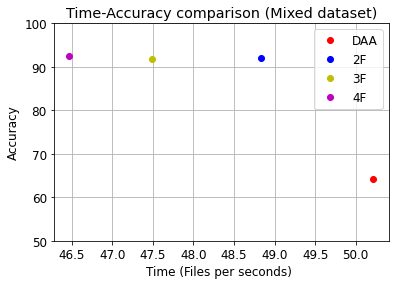

In [42]:
time = [time_spentDAA/files_analyzedDAA,time_spent2F/files_analyzed2F,time_spent3Favg/files_analyzed3Favg,time_spent4Favg/files_analyzed4Favg]
time1= [1/time[0],1/time[1],1/time[2],1/time[3]]
acc_mix = [np.mean(acc_DAA_mix),np.mean(acc_2F_mix),np.mean(acc_3F_mix),np.mean(acc_4F_mix)]

plt.plot(time1[0], acc_mix[0],'ro', label="DAA")
plt.plot(time1[1], acc_mix[1],'bo', label="2F")
plt.plot(time1[2], acc_mix[2],'yo', label="3F")
plt.plot(time1[3], acc_mix[3],'mo', label="4F")
plt.legend()
plt.grid()
plt.ylim([50 ,100])
plt.ylabel('Accuracy')
plt.xlabel('Time (Files per seconds) ')
plt.title('Time-Accuracy comparison (Mixed dataset)')
plt.show()

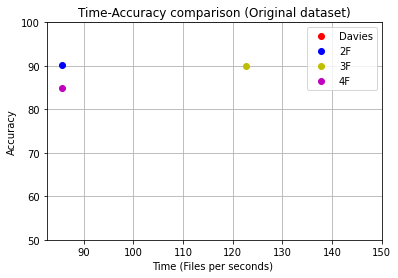

In [126]:
time = [time_spentDAA/files_analyzedDAA,time_spent2F/files_analyzed2F,time_spent3Fmax/files_analyzed3Fmax,time_spent3Favg/files_analyzed3Favg,time_spent4Fmax/files_analyzed4Fmax,time_spent4Favg/files_analyzed4Favg]
time1= [1/time[0],1/time[1],1/time[2],1/time[3],1/time[4],1/time[5]]
acc_org = [np.mean(acc_DAA_org),np.mean(acc_2F_org),np.mean(acc_3F_org_max),np.mean(acc_3F_org),np.mean(acc_4F_org_max),np.mean(acc_4F_org)]

plt.plot(time1[0], acc_org[0],'ro', label="Davies")
plt.plot(time1[1], acc_org[1],'bo', label="2F")
plt.plot(time1[2], acc_org[3],'yo', label="3F")
plt.plot(time1[3], acc_org[4],'mo', label="4F")
plt.legend()
plt.grid()
plt.ylim([50 ,100])
plt.ylabel('Accuracy')
plt.xlabel('Time (Files per seconds) ')
plt.title('Time-Accuracy comparison (Original dataset)')
plt.show()